#Разработка модели для прогнозирование температуры звезды на основе данных  обсерватории «Небо на ладони»

Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

**Цели работы:**

-изучит данные обсерватории «Небо на ладони»

-проанализировать данные

-обучить нейросети определять температуру на поверхности обнаруженных звёзд

-метрика RMSE не должна превышать 4500

**Описание данных:**

-Относительная светимость L/Lo — светимость звезды относительно Солнца.

-Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.

-Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.

-Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.

-Тип звезды — Номер, соответствующий типу: Коричневый карлик-0, Красный карлик-1, Белый карлик-2, Звёзды главной последовательности-3, Сверхгигант-4,Гипергигант-5

-Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

**Краткий план работы:**

-провести предобработку данных: устранить пропуски, дубликаты

-исследовать данные: найти закономерности, зависимости, визуализировать результаты

-обучить при помощи нейросетей модель, протестировать разные архитектуры сетей, попробовать разные методы инициализации, оптимизации и тд. Улучшить качество модели

-добиться качества целевой метрики согласно критерию успеха

## Загрузка данных

In [ ]:
!pip install phik -q
!pip install torchmetrics -q

In [ ]:
!pip install -U scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import torch
import phik

import torch.nn as nn
from torchmetrics import MeanSquaredError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Данные представленны в 1 файле, прочитаем его и сохраним

In [ ]:
df = pd.read_csv('/datasets/6_class.csv')
df.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/csv/star.csv')
# df.head()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


В данных имеются, 1 колонка типа object, 3 колонки типа int, 3 колонки типа float, 240 строк

## Предобработка и анализ данных

In [ ]:
df.isna().mean()

Unnamed: 0                0.0
Temperature (K)           0.0
Luminosity(L/Lo)          0.0
Radius(R/Ro)              0.0
Absolute magnitude(Mv)    0.0
Star type                 0.0
Star color                0.0
dtype: float64

Пропусков в данных не наблюдаем

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.drop('Unnamed: 0', axis=1).duplicated().sum()

0

Явных дубликатов нет

Проверим значения категориальных переменных:

In [ ]:
df['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Наблюдаем значения одних и тех же цветов звезд написанных в разных регистрах, стилях. Приведем их к одному виду

In [ ]:
df['Star color'] = df['Star color'].apply(lambda x: 'Blue White'
                                          if any(_ in x for _ in ['Blue white', 'Blue-white', 'Blue white ', 'Blue-White'])
                                          else x)
df['Star color'] = df['Star color'].apply(lambda x: 'White'
                                          if any(_ in x for _ in ['white', 'Whitish'])
                                          else x)
df['Star color'] = df['Star color'].apply(lambda x: 'Yellow White'
                                          if any(_ in x for _ in ['Yellowish White', 'yellow-white', 'White-Yellow'])
                                          else x)
df['Star color'] = df['Star color'].apply(lambda x: 'Yellow Orange'
                                          if x == 'Pale yellow orange'
                                          else x)
df['Star color'] = df['Star color'].apply(lambda x: 'Blue'
                                          if x == 'Blue '
                                          else x)
df['Star color'] = df['Star color'].apply(lambda x: 'Yellow'
                                          if any(_ in x for _ in ['Yellowish', 'yellowish'])
                                          else x)
df['Star color'] = df['Star color'].apply(lambda x: 'Orange Red'
                                          if x == 'Orange-Red'
                                          else x)

In [ ]:
df['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellow White', 'Yellow Orange',
       'Blue', 'Orange', 'Yellow', 'Orange Red'], dtype=object)

In [ ]:
df['Star type'].unique()

array([0, 1, 2, 3, 4, 5])

Категории типов звезд представленны корректно

In [ ]:
df.drop('Unnamed: 0', axis=1).duplicated().sum()

0

Дубликатов после предобработки не появилось

### Категориальные признаки

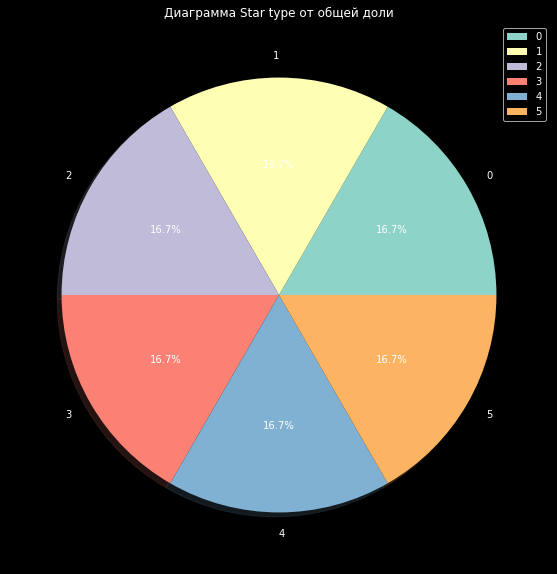

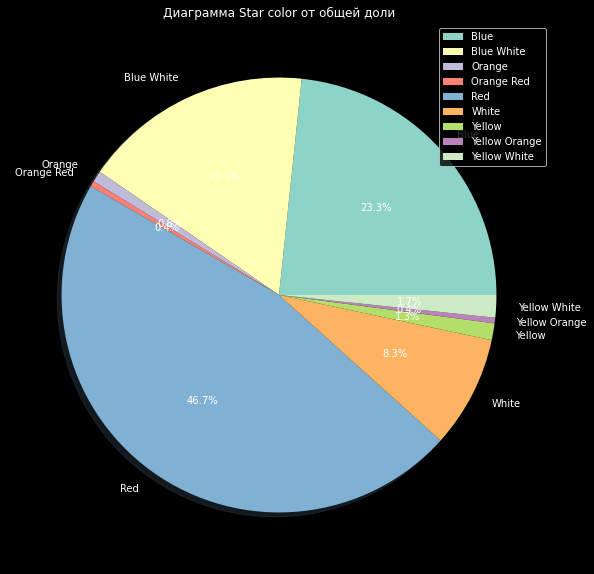

In [ ]:
for colum in ['Star type', 'Star color']:
    fig, ax = plt.subplots(figsize=(12, 10))
    x = df.groupby(colum)['Unnamed: 0'].count()
    x = (x/len(df) * 100).reset_index()
    labels = x[colum]
    x = x['Unnamed: 0']
    plt.pie(x, labels=labels, autopct='%1.1f%%', shadow=True)
    plt.legend(loc="best")
    plt.title('Диаграмма '+ colum +' от общей доли')
    plt.show()
    print()

-Значения 'Star type'(тип звезды) типы звезд распределенны +- равномерно по данным

-Значения 'Star color'(Звёздный цвет) преобладает цвет звезд красного оттенка 'Red'(46,7%), меньше звезд с синего оттенка: 'Blue White', 'Blue' (по ~ 23-24%),
желтый оттенок занимает самую наименьшую часть в данных (~10%)

Соберем все немногочисленные звезды желтого оттенка в отдельную категорию other

In [ ]:
df['Star color'] = df['Star color'].apply(lambda x: 'other'
                                          if any(_ in x for _ in ['Yellow', 'Yellow Orange', 'Yellow White ', 'Orange', 'Orange Red'])
                                          else x)
df['Star color'].unique()

array(['Red', 'Blue White', 'White', 'other', 'Blue'], dtype=object)

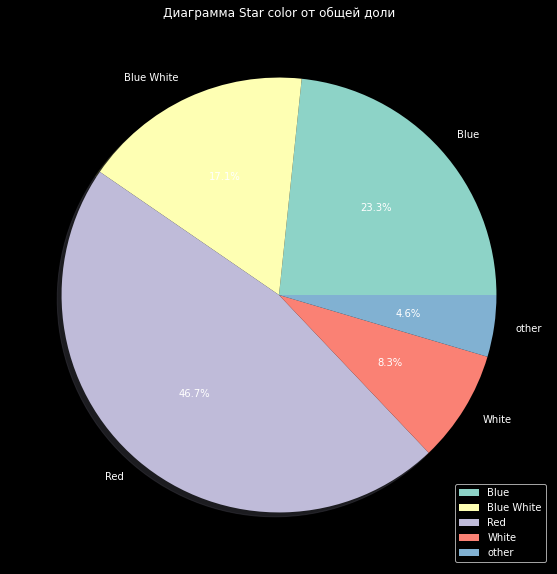

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
x = df.groupby('Star color')['Unnamed: 0'].count()
x = (x/len(df) * 100).reset_index()
labels = x['Star color']
x = x['Unnamed: 0']
plt.pie(x, labels=labels, autopct='%1.1f%%', shadow=True)
plt.legend(loc="best")
plt.title('Диаграмма '+ 'Star color' +' от общей доли')
plt.show()

### Кол-ые признаки

Temperature (K)
count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: Temperature (K), dtype: float64


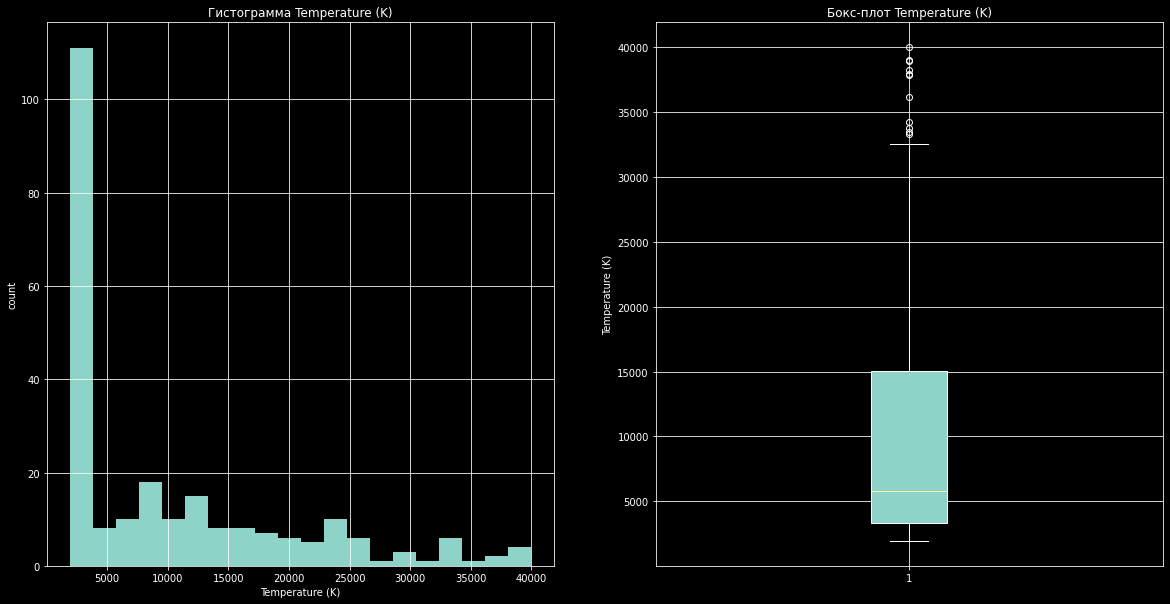

Luminosity(L/Lo)
count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: Luminosity(L/Lo), dtype: float64


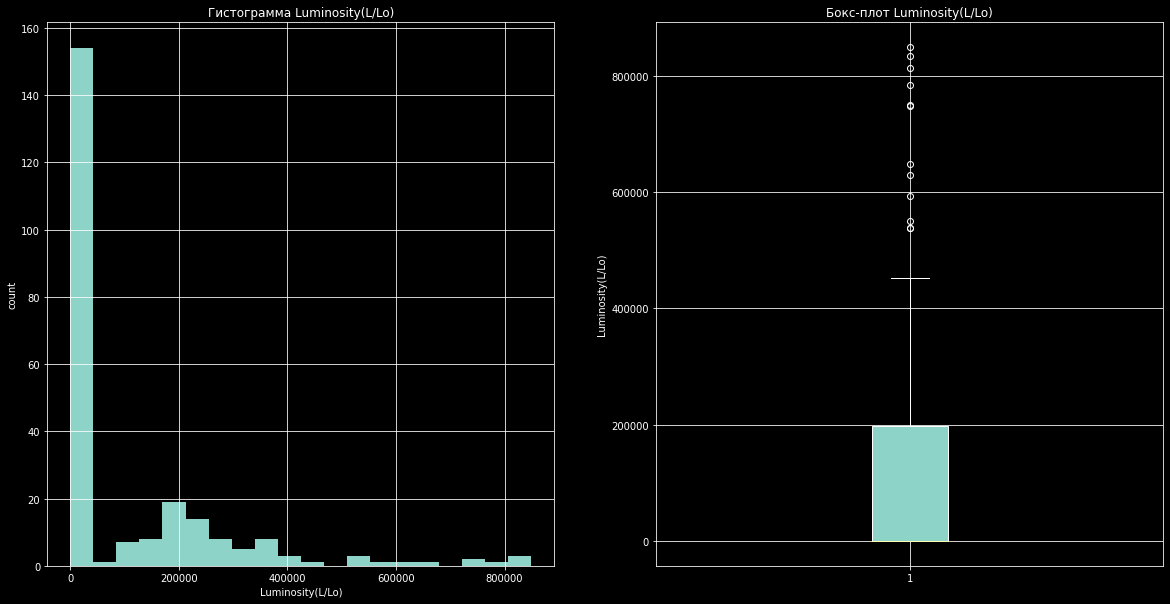

Radius(R/Ro)
count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: Radius(R/Ro), dtype: float64


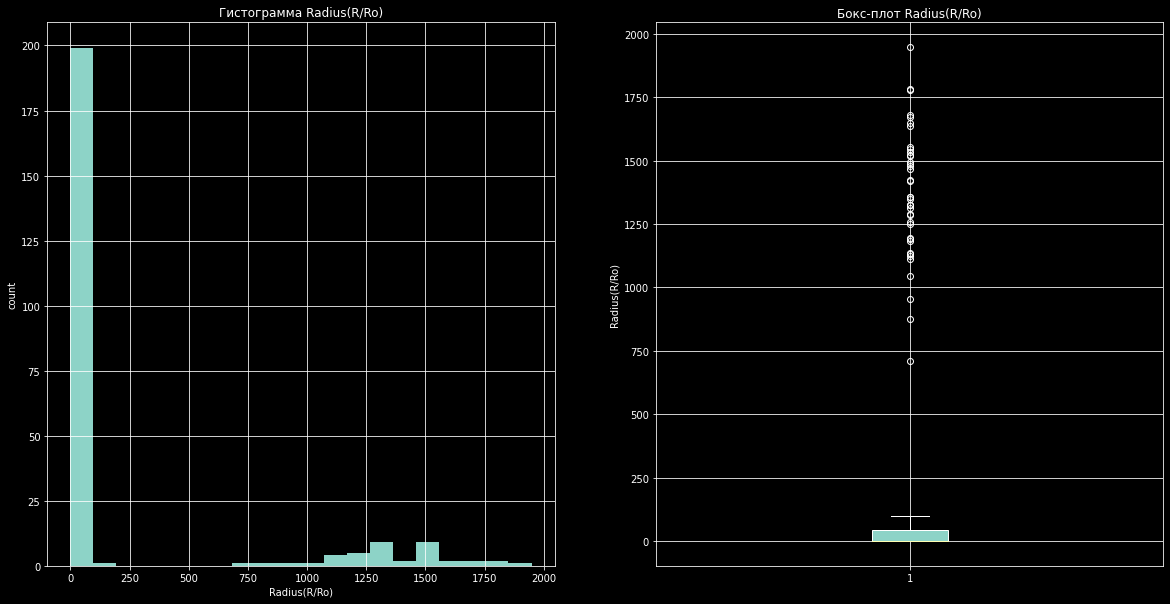

Absolute magnitude(Mv)
count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: Absolute magnitude(Mv), dtype: float64


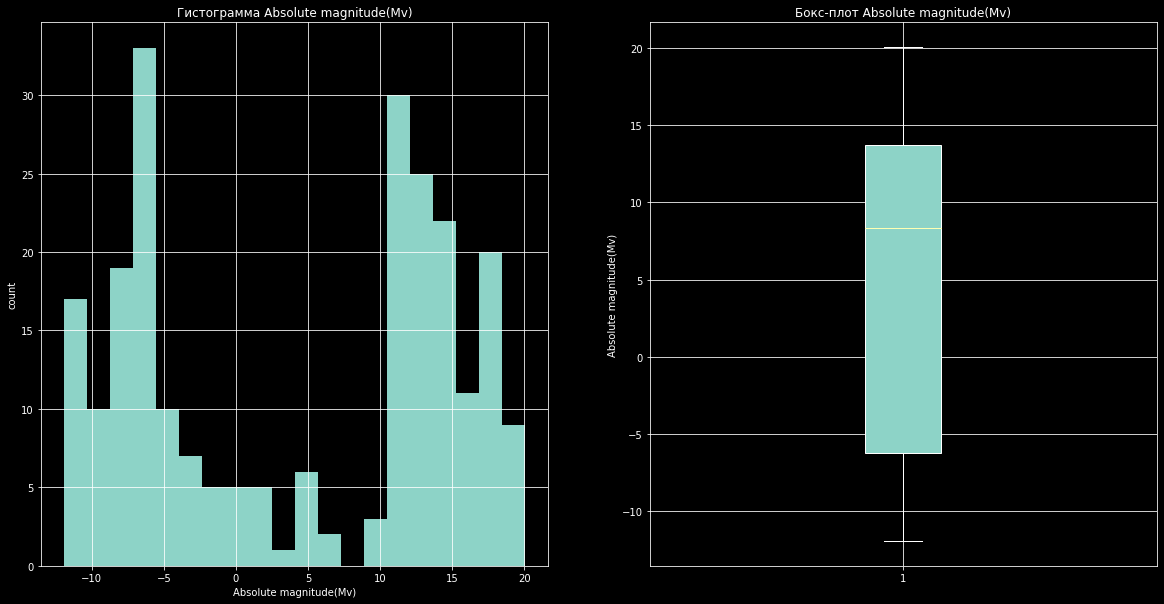

In [ ]:
for colum in ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']:
    print(colum)
    print(df[colum].describe())
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    ax[0].hist(df[colum], bins=20)
    ax[0].set_title('Гистограмма ' + colum)
    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].grid(True)

    if df[colum].isna().sum() != 0:
        ax[1].boxplot(df[colum].fillna(df[colum].mean()), patch_artist=True)

    else:
        ax[1].boxplot(df[colum], patch_artist=True)

    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum)
    ax[1].grid(True)
    plt.show()

-**'Temperature (K)'**(Абсолютная температура) целевой признак напоминает распределение Пуасона со 'скосом' к левому краю разброс варьируется от 1939 до 40000, в среднем 10497

Присутсвуют слегка выбивающиеся значения по правой стороне распределения

-**'Luminosity(L/Lo)'**(Относительная светимость) напоминает распределение Пуасона со 'скосом' к левому краю разброс варьируется от 0 до 849420, в среднем 107188

Присутсвуют слегка выбивающиеся значения по правой стороне распределения

-**'Radius(R/Ro)'**(Относительный радиус) напоминает распределение Пуасона со 'скосом' к левому краю разброс варьируется от 0 до 1948, в среднем 237

Присутствуют аномальные значения в правой части распределения

-**'Absolute magnitude(Mv)'**(Абсолютная звёздная величина) напоминает нормальное распределение с двумя пиковыми значениями на ~-7 и ~12, разброс варьируется от -11.9 до 20.06, в среднем 4.38

Аномальных значений не наблюдаем

### Корреляционный анализ

Построим "хитмап" по матрице корреляций Фик, посмотрим на связь признаков с целевой переменной

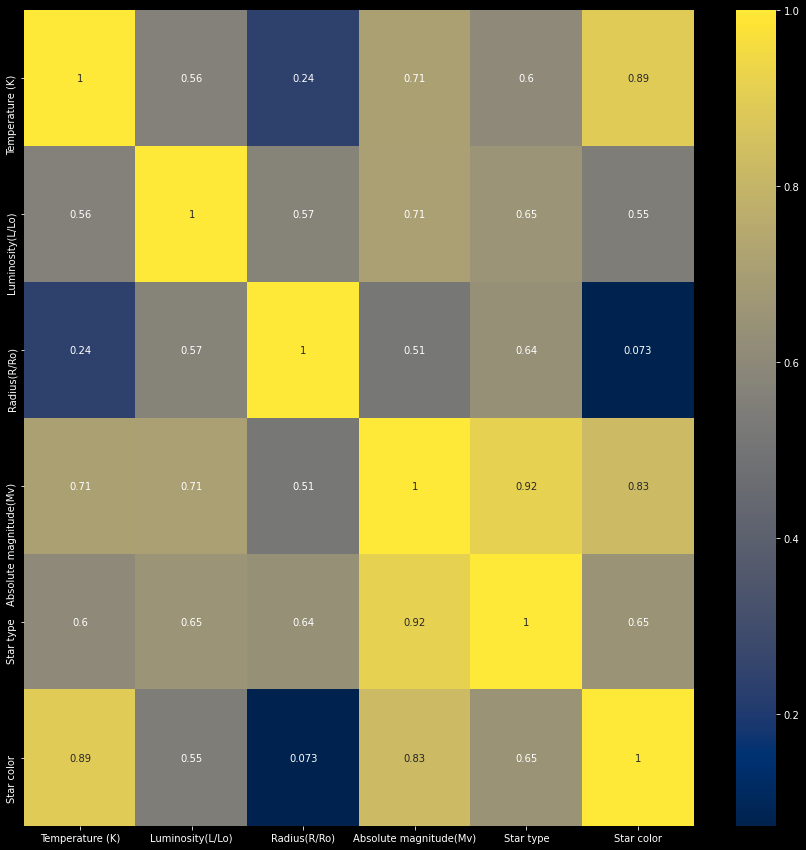

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.drop('Unnamed: 0', axis=1).phik_matrix(interval_cols = ['Temperature (K)','Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
                                                      ),annot=True, cmap='cividis').legend = False

Наблюдаем сильную корреляцию между 'Absolute magnitude(Mv)' и 'Star type'

## Построение базовой нейронной сети

Зафиксируем 'случайность' в генераторах torch, numpy

In [ ]:
torch.manual_seed(37)
torch.cuda.manual_seed(37)
np.random.seed(37)

In [ ]:
def set_seed(seed: int = 37) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

Разделим данные на тренировочные, вылидационные и тестовые. Выделим таргет из данных:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Unnamed: 0', 'Temperature (K)'], axis=1),
                                                    df['Temperature (K)'],test_size=0.3,
                                                    shuffle=True, random_state=37)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, train_size=0.5, random_state=37, shuffle=True)

Сохраним названия колонок для удобства обращения

In [ ]:
num_colum = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
cat_colum = ['Star type', 'Star color']

Масштабирование и кодирование:

In [ ]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_colum])
X_valid_ohe = encoder.transform(X_valid[cat_colum])
X_test_ohe = encoder.transform(X_test[cat_colum])

encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_colum])
X_valid_scaled = scaler.transform(X_valid[num_colum])
X_test_scaled = scaler.transform(X_test[num_colum])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_colum)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_colum)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_colum)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_valid = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [ ]:
len(X_train)

168

In [ ]:
X_train.head()

,Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star color_Blue White,Star color_Red,Star color_White,Star color_other,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.626236,-0.477138,0.625584
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.626236,-0.477172,0.758603
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.626236,-0.477425,0.709735
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.894355,1.788014,-1.404603
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.626236,-0.477045,0.835961


In [ ]:
len(X_valid)

36

In [ ]:
X_valid.head()

,Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star color_Blue White,Star color_Red,Star color_White,Star color_other,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.089217,2.410419,-1.426301
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.019185,-0.454919,-0.959320
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.626193,-0.475148,-0.171585
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.621450,-0.466963,-0.650830
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.626236,-0.477666,0.963320


In [ ]:
len(X_test)

36

In [ ]:
X_test.head()

,Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star color_Blue White,Star color_Red,Star color_White,Star color_other,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.626236,-0.477466,1.238791
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.626236,-0.477667,0.812376
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.647488,-0.320192,-1.051773
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.535232,-0.465546,-0.787622
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.626236,-0.476969,0.552943


Для работы с torch переведем данные в тензоры

In [ ]:
X_train = torch.FloatTensor(X_train.values)
X_valid = torch.FloatTensor(X_valid.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_valid = torch.FloatTensor(y_valid.values)
y_test = torch.FloatTensor(y_test.values)

Для модели по умолчанию возьмем архитектуру сети с 2-мя скрытыми слоями, количество нейронов в скрытых слоях: 500, 800 соответственно. В качестве алгоритма оптимизации выберем Adam, скорость обучения возьмем 1e-3. Учить будем 100 эпох проверяя результат каждые 10 эпох

In [ ]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 500
n_hidden_neurons_2 = 800
n_out_neurons = 1

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss = nn.MSELoss()
rmse = MeanSquaredError(squared = False)

num_epochs = 100

In [ ]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    preds = net.forward(X_train).flatten()

    loss_value = loss(preds, y_train)

    loss_value.backward()

    optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        print(rmse(net(X_valid).squeeze(-1), y_valid))

tensor(11636.8652, grad_fn=<SqueezeBackward0>)
tensor(11629.9824, grad_fn=<SqueezeBackward0>)
tensor(11614.2334, grad_fn=<SqueezeBackward0>)
tensor(11582.3555, grad_fn=<SqueezeBackward0>)
tensor(11523.5928, grad_fn=<SqueezeBackward0>)
tensor(11424.7715, grad_fn=<SqueezeBackward0>)
tensor(11271.9609, grad_fn=<SqueezeBackward0>)
tensor(11051.5498, grad_fn=<SqueezeBackward0>)
tensor(10751.9561, grad_fn=<SqueezeBackward0>)
tensor(10365.8223, grad_fn=<SqueezeBackward0>)
tensor(9943.5957, grad_fn=<SqueezeBackward0>)


## Улучшение нейронной сети

Настроим перебор гиперпараметров нашей сети, будем перебирать кол-во нейронов в скрытых слоях, возьмем 15 итераций перебора. Кол-во эпох повысим до 1000, каждые 100 эпох будем проверять результат

In [ ]:
h1 = list(range(100, 500, 50))
h2 = list(range(100,500, 50))
num_epochs = 1000
n_iter = 15

In [ ]:
best_result = []
for i in range(n_iter):

    n_hidden_neurons_1 = h1[np.random.randint(0, len(h1))]
    n_hidden_neurons_2 = h2[np.random.randint(0, len(h2))]

    net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
    )

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = net.forward(X_train).flatten()

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()

        if epoch % 100 == 0 or epoch == num_epochs - 1:
            net.eval()
            result = rmse(net(X_valid).squeeze(-1), y_valid)
            print(f'кол-во нейронов в 1-ом слое: {n_hidden_neurons_1}, кол-во нейронов в 2-ом слое: {n_hidden_neurons_2},  номер эпохи: {epoch}, RMSE: {result}')
            print()
            best_result.append(result)

кол-во нейронов в 1-ом слое: 450, кол-во нейронов в 2-ом слое: 250,  номер эпохи: 0, RMSE: 11637.1103515625

кол-во нейронов в 1-ом слое: 450, кол-во нейронов в 2-ом слое: 250,  номер эпохи: 100, RMSE: 11103.83203125

кол-во нейронов в 1-ом слое: 450, кол-во нейронов в 2-ом слое: 250,  номер эпохи: 200, RMSE: 8173.56689453125

кол-во нейронов в 1-ом слое: 450, кол-во нейронов в 2-ом слое: 250,  номер эпохи: 300, RMSE: 5647.0546875

кол-во нейронов в 1-ом слое: 450, кол-во нейронов в 2-ом слое: 250,  номер эпохи: 400, RMSE: 4946.603515625

кол-во нейронов в 1-ом слое: 450, кол-во нейронов в 2-ом слое: 250,  номер эпохи: 500, RMSE: 4676.544921875

кол-во нейронов в 1-ом слое: 450, кол-во нейронов в 2-ом слое: 250,  номер эпохи: 600, RMSE: 4103.80859375

кол-во нейронов в 1-ом слое: 450, кол-во нейронов в 2-ом слое: 250,  номер эпохи: 700, RMSE: 3537.530029296875

кол-во нейронов в 1-ом слое: 450, кол-во нейронов в 2-ом слое: 250,  номер эпохи: 800, RMSE: 3382.22607421875

кол-во нейронов

In [ ]:
print(f"лучший результат обучения, RMSE: {min(best_result)}")

лучший результат обучения, RMSE: 3333.223876953125


### Нахождение лучших параметров и анализ работы 3-х слойной архитектуры

Добавим 3-ий скр. слой в нашу сеть(до 500 нейронов), добавим перебор learning_rate, функций активации. Обучение будем проводить по батчам c перебором размера батча и перебором доли Dropout нейронов после каждого слоя. Повысим кол-во итераций перебора до 50

In [ ]:
h3 = list(range(100,500, 50))
lr = [1e-3, 1e-2, 1e-1]
batch_sizes = [16, 32, 64, 128]
p_drop = [0, 0.2, 0.5]
af = [nn.Tanh(), nn.Sigmoid(), nn.ReLU()]
n_iter = 50

Добавим метод init_weights для инициализации слоёв. Будем инициализировать веса с помощью нормального распределения с математическим ожиданием 0.5 и среднеквадратичным отклонением 2, а смещения — с помощью нормального распределения с математическим ожиданием 0.5 и среднеквадратичным отклонением 1

In [ ]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.normal_(layer.weight, 0.5, 2)
        nn.init.normal_(layer.bias, -0.5, 1)

In [ ]:
best_result = []
n_hidden_neurons_1_result = []
n_hidden_neurons_2_result = []
n_hidden_neurons_3_result = []
epoch_result = []
af1_result = []
af2_result = []
af3_result = []
lr_result = []
bs_result = []
p_drop_1_result = []
p_drop_2_result = []
p_drop_3_result = []

for i in range(n_iter):
    n_hidden_neurons_1 = h1[np.random.randint(0, len(h1))]
    n_hidden_neurons_2 = h2[np.random.randint(0, len(h2))]
    n_hidden_neurons_3 = h3[np.random.randint(0, len(h3))]
    af1 = af[np.random.randint(0, len(af))]
    af2 = af[np.random.randint(0, len(af))]
    af3 = af[np.random.randint(0, len(af))]
    lr_net = lr[np.random.randint(0, len(lr))]
    batch_size = batch_sizes[np.random.randint(0, len(batch_sizes))]
    drop_1 = p_drop[np.random.randint(0, len(p_drop))]
    drop_2 = p_drop[np.random.randint(0, len(p_drop))]
    drop_3 = p_drop[np.random.randint(0, len(p_drop))]

    data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

    net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    af1,
    nn.Dropout(p=drop_1),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    af2,
    nn.Dropout(p=drop_2),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    af3,
    nn.Dropout(p=drop_3),
    nn.Linear(n_hidden_neurons_3, n_out_neurons)
    )
    net.apply(init_weights)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        for X_batch, y_batch in data_loader:
            preds = net.forward(X_batch).flatten()
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()

        if epoch % 100 == 0 or epoch == num_epochs - 1:
            net.eval()
            result = rmse(net(X_valid).squeeze(-1), y_valid)
            print(f'кол-во нейронов в 1-ом слое: {n_hidden_neurons_1}, кол-во нейронов в 2-ом слое: {n_hidden_neurons_2}, кол-во нейронов в 3-ем слое: {n_hidden_neurons_3},  номер эпохи: {epoch}, RMSE: {result}')
            print(f'функция активации 1-го слоя: {af1}, функция активации 2-го слоя: {af2}, функция активации 3-го слоя: {af3},  скорость обучения: {lr_net}')
            print(f'размер батча: {batch_size}, dropout 1-го слоя: {drop_1}, dropout 2-го слоя: {drop_2},  dropout 3-го слоя: {drop_3}')
            print()
            best_result.append(result)
            n_hidden_neurons_1_result.append(n_hidden_neurons_1)
            n_hidden_neurons_2_result.append(n_hidden_neurons_2)
            n_hidden_neurons_3_result.append(n_hidden_neurons_3)
            epoch_result.append(epoch)
            af1_result.append(af1)
            af2_result.append(af2)
            af3_result.append(af3)
            lr_result.append(lr_net)
            bs_result.append(batch_size)
            p_drop_1_result.append(drop_1)
            p_drop_2_result.append(drop_2)
            p_drop_3_result.append(drop_3)

кол-во нейронов в 1-ом слое: 250, кол-во нейронов в 2-ом слое: 100, кол-во нейронов в 3-ем слое: 300,  номер эпохи: 0, RMSE: 281904.5
функция активации 1-го слоя: Sigmoid(), функция активации 2-го слоя: ReLU(), функция активации 3-го слоя: ReLU(),  скорость обучения: 0.001
размер батча: 128, dropout 1-го слоя: 0.5, dropout 2-го слоя: 0.2,  dropout 3-го слоя: 0.5

кол-во нейронов в 1-ом слое: 250, кол-во нейронов в 2-ом слое: 100, кол-во нейронов в 3-ем слое: 300,  номер эпохи: 100, RMSE: 6000.7099609375
функция активации 1-го слоя: Sigmoid(), функция активации 2-го слоя: ReLU(), функция активации 3-го слоя: ReLU(),  скорость обучения: 0.001
размер батча: 128, dropout 1-го слоя: 0.5, dropout 2-го слоя: 0.2,  dropout 3-го слоя: 0.5

кол-во нейронов в 1-ом слое: 250, кол-во нейронов в 2-ом слое: 100, кол-во нейронов в 3-ем слое: 300,  номер эпохи: 200, RMSE: 5381.6416015625
функция активации 1-го слоя: Sigmoid(), функция активации 2-го слоя: ReLU(), функция активации 3-го слоя: ReLU(),  с

In [ ]:
print(f"лучший результат обучения, RMSE: {min(best_result)}")

лучший результат обучения, RMSE: 2806.122802734375


Сохраним результат подбора модели:

In [ ]:
best_result_ = min(best_result)
best_id = best_result.index(best_result_)
best_id

487

In [ ]:
best_model_3_hidden = []
best_model_3_hidden.append(f"RMSE: {min(best_result)}")
best_model_3_hidden.append(f"Нейроны 1 слой: {n_hidden_neurons_1_result[best_id]}")
best_model_3_hidden.append(f"Нейроны 2 слой: {n_hidden_neurons_2_result[best_id]}")
best_model_3_hidden.append(f"Нейроны 3 слой: {n_hidden_neurons_3_result[best_id]}")
best_model_3_hidden.append(f"Функ. акт. 1 слоя: {af1_result[best_id]}")
best_model_3_hidden.append(f"Функ. акт. 2 слоя: {af2_result[best_id]}")
best_model_3_hidden.append(f"Функ. акт. 3 слоя: {af3_result[best_id]}")
best_model_3_hidden.append(f"learning rate: {lr_result[best_id]}")
best_model_3_hidden.append(f"Номер эпохи: {epoch_result[best_id]}")
best_model_3_hidden.append(f"dropout 1 слоя: {p_drop_1_result[best_id]}")
best_model_3_hidden.append(f"dropout 2 слоя: {p_drop_2_result[best_id]}")
best_model_3_hidden.append(f"dropout 3 слоя: {p_drop_3_result[best_id]}")
best_model_3_hidden.append(f"размер батча: {bs_result[best_id]}")

print('лучшие параметры сети с 3-мя скр. слоями:')
best_model_3_hidden

лучшие параметры сети с 3-мя скр. слоями:


['RMSE: 2806.122802734375',
 'Нейроны 1 слой: 250',
 'Нейроны 2 слой: 400',
 'Нейроны 3 слой: 250',
 'Функ. акт. 1 слоя: Tanh()',
 'Функ. акт. 2 слоя: Tanh()',
 'Функ. акт. 3 слоя: ReLU()',
 'learning rate: 0.001',
 'Номер эпохи: 300',
 'dropout 1 слоя: 0.5',
 'dropout 2 слоя: 0',
 'dropout 3 слоя: 0',
 'размер батча: 16']

Обучаем лучший вариант архитектуры сети для графика 'факт-проноз'

In [ ]:
n_hidden_neurons_1 = 250
n_hidden_neurons_2 = 400
n_hidden_neurons_3 = 250
af1 = nn.Tanh()
af2 = nn.Tanh()
af3 = nn.ReLU()
lr_net = 1e-3
batch_size = 16
drop_1 = 0.5
drop_2 = 0
drop_3 = 0
num_epochs = 500

data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

net = nn.Sequential(
nn.Linear(n_in_neurons, n_hidden_neurons_1),
af1,
nn.Dropout(p=drop_1),
nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
af2,
nn.Dropout(p=drop_2),
nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
af3,
nn.Dropout(p=drop_3),
nn.Linear(n_hidden_neurons_3, n_out_neurons)
)
net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    for X_batch, y_batch in data_loader:
        preds = net.forward(X_batch).flatten()
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    if epoch % 100 == 0 or epoch == num_epochs - 1:
        net.eval()
result = rmse(net(X_valid).squeeze(-1), y_valid)
print(f"результат RMSE на валидации: {result}")

результат RMSE на валидации: 3255.090087890625


График факт-проноз:

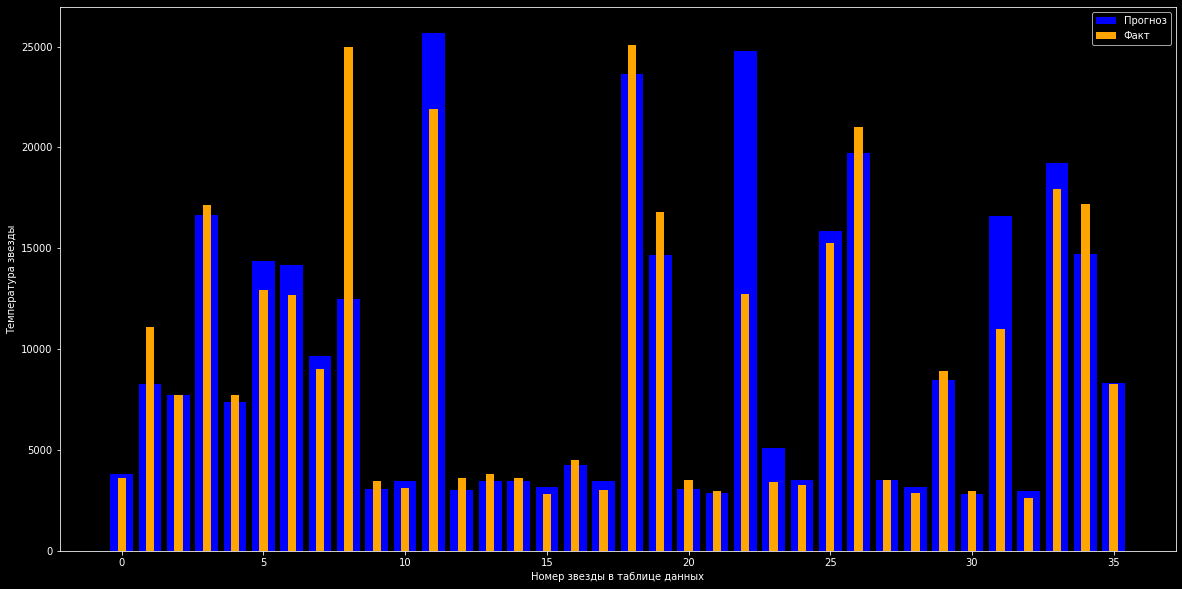

In [ ]:
pred = pd.DataFrame(net(X_valid).squeeze(-1).detach().numpy(), columns=['температура'])
y_val = pd.DataFrame(y_valid.detach().numpy(), columns=['температура'])

fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x=pred.index, height=pred['температура'], color='Blue' , label='Прогноз')
plt.bar(x=y_val.index, height=y_val['температура'], color='Orange', label='Факт', width= 0.3)
plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды')
plt.legend(loc="best")
plt.show()

### Нахождение лучших параметров и анализ работы 2-х слойной архитектуры

Снова обучим архитектуру сети с 2-мя скрытыми слоями, но увеличим кол-во нейронов в слоях (до 1500), так же попробуем перебор вариантов функций активации, learning rate, размера батча, доли dropout после слоев

In [ ]:
h1 = list(range(300,1500, 50))
h2 = list(range(300,1500, 50))

In [ ]:
best_result = []
n_hidden_neurons_1_result = []
n_hidden_neurons_2_result = []
epoch_result = []
af1_result = []
af2_result = []
lr_result = []
bs_result = []
p_drop_1_result = []
p_drop_2_result = []
for i in range(n_iter):
    n_hidden_neurons_1 = h1[np.random.randint(0, len(h1))]
    n_hidden_neurons_2 = h2[np.random.randint(0, len(h2))]
    af1 = af[np.random.randint(0, len(af))]
    af2 = af[np.random.randint(0, len(af))]
    lr_net = lr[np.random.randint(0, len(lr))]
    batch_size = batch_sizes[np.random.randint(0, len(batch_sizes))]
    drop_1 = p_drop[np.random.randint(0, len(p_drop))]
    drop_2 = p_drop[np.random.randint(0, len(p_drop))]

    data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

    net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    af1,
    nn.Dropout(p=drop_1),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    af2,
    nn.Dropout(p=drop_2),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
    )
    net.apply(init_weights)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        for X_batch, y_batch in data_loader:
            preds = net.forward(X_batch).flatten()
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()

        if epoch % 100 == 0 or epoch == num_epochs - 1:
            net.eval()
            result = rmse(net(X_valid).squeeze(-1), y_valid)
            print(f'кол-во нейронов в 1-ом слое: {n_hidden_neurons_1}, кол-во нейронов в 2-ом слое: {n_hidden_neurons_2},  номер эпохи: {epoch}, RMSE: {result}')
            print(f'функция активации 1-го слоя: {af1}, функция активации 2-го слоя: {af2},  скорость обучения: {lr_net}')
            print(f'размер батча: {batch_size}, dropout 1-го слоя: {drop_1}, dropout 2-го слоя: {drop_2}')
            print()
            best_result.append(result)
            n_hidden_neurons_1_result.append(n_hidden_neurons_1)
            n_hidden_neurons_2_result.append(n_hidden_neurons_2)
            epoch_result.append(epoch)
            af1_result.append(af1)
            af2_result.append(af2)
            lr_result.append(lr_net)
            bs_result.append(batch_size)
            p_drop_1_result.append(drop_1)
            p_drop_2_result.append(drop_2)

кол-во нейронов в 1-ом слое: 1000, кол-во нейронов в 2-ом слое: 350,  номер эпохи: 0, RMSE: 11544.6611328125
функция активации 1-го слоя: Tanh(), функция активации 2-го слоя: Tanh(),  скорость обучения: 0.01
размер батча: 32, dropout 1-го слоя: 0, dropout 2-го слоя: 0.2

кол-во нейронов в 1-ом слое: 1000, кол-во нейронов в 2-ом слое: 350,  номер эпохи: 100, RMSE: 9791.56640625
функция активации 1-го слоя: Tanh(), функция активации 2-го слоя: Tanh(),  скорость обучения: 0.01
размер батча: 32, dropout 1-го слоя: 0, dropout 2-го слоя: 0.2

кол-во нейронов в 1-ом слое: 1000, кол-во нейронов в 2-ом слое: 350,  номер эпохи: 200, RMSE: 8600.6083984375
функция активации 1-го слоя: Tanh(), функция активации 2-го слоя: Tanh(),  скорость обучения: 0.01
размер батча: 32, dropout 1-го слоя: 0, dropout 2-го слоя: 0.2

кол-во нейронов в 1-ом слое: 1000, кол-во нейронов в 2-ом слое: 350,  номер эпохи: 300, RMSE: 7602.4990234375
функция активации 1-го слоя: Tanh(), функция активации 2-го слоя: Tanh(), 

In [ ]:
print(f"лучший результат обучения, RMSE: {min(best_result)}")

лучший результат обучения, RMSE: 2880.549560546875


Зафиксируем гиперпараметры лучшей модели:

In [ ]:
best_result_ = min(best_result)
best_id = best_result.index(best_result_)
best_id

38

In [ ]:
best_model_2_hidden = []
best_model_2_hidden.append(f"RMSE: {min(best_result)}")
best_model_2_hidden.append(f"Нейроны 1 слой: {n_hidden_neurons_1_result[best_id]}")
best_model_2_hidden.append(f"Нейроны 2 слой: {n_hidden_neurons_2_result[best_id]}")
best_model_2_hidden.append(f"Функ. акт. 1 слоя: {af1_result[best_id]}")
best_model_2_hidden.append(f"Функ. акт. 2 слоя: {af2_result[best_id]}")
best_model_2_hidden.append(f"learning rate: {lr_result[best_id]}")
best_model_2_hidden.append(f"Номер эпохи: {epoch_result[best_id]}")
best_model_2_hidden.append(f"dropout 1 слоя: {p_drop_1_result[best_id]}")
best_model_2_hidden.append(f"dropout 2 слоя: {p_drop_2_result[best_id]}")
best_model_2_hidden.append(f"размер батча: {bs_result[best_id]}")

print('лучшие параметры сети с 2-мя скр. слоями:')
best_model_2_hidden

лучшие параметры сети с 2-мя скр. слоями:


['RMSE: 2880.549560546875',
 'Нейроны 1 слой: 950',
 'Нейроны 2 слой: 300',
 'Функ. акт. 1 слоя: Tanh()',
 'Функ. акт. 2 слоя: ReLU()',
 'learning rate: 0.1',
 'Номер эпохи: 200',
 'dropout 1 слоя: 0.2',
 'dropout 2 слоя: 0.5',
 'размер батча: 64']

Лучший вариант архитектуры сети для графика 'факт-проноз':

In [ ]:
n_hidden_neurons_1 = 850
n_hidden_neurons_2 = 300
af1 = nn.Tanh()
af2 = nn.Tanh()
lr_net = 1e-1
batch_size = 16
drop_1 = 0.2
drop_2 = 0
num_epochs = 400

data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

net = nn.Sequential(
nn.Linear(n_in_neurons, n_hidden_neurons_1),
af1,
nn.Dropout(p=drop_1),
nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
af2,
nn.Dropout(p=drop_2),
nn.Linear(n_hidden_neurons_2, n_out_neurons)
)
net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    for X_batch, y_batch in data_loader:
        preds = net.forward(X_batch).flatten()
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    if epoch % 100 == 0 or epoch == num_epochs - 1:
        net.eval()
result = rmse(net(X_valid).squeeze(-1), y_valid)
print(f"результат RMSE на валидации: {result}")

результат RMSE на валидации: 6944.8154296875


График факт-проноз:

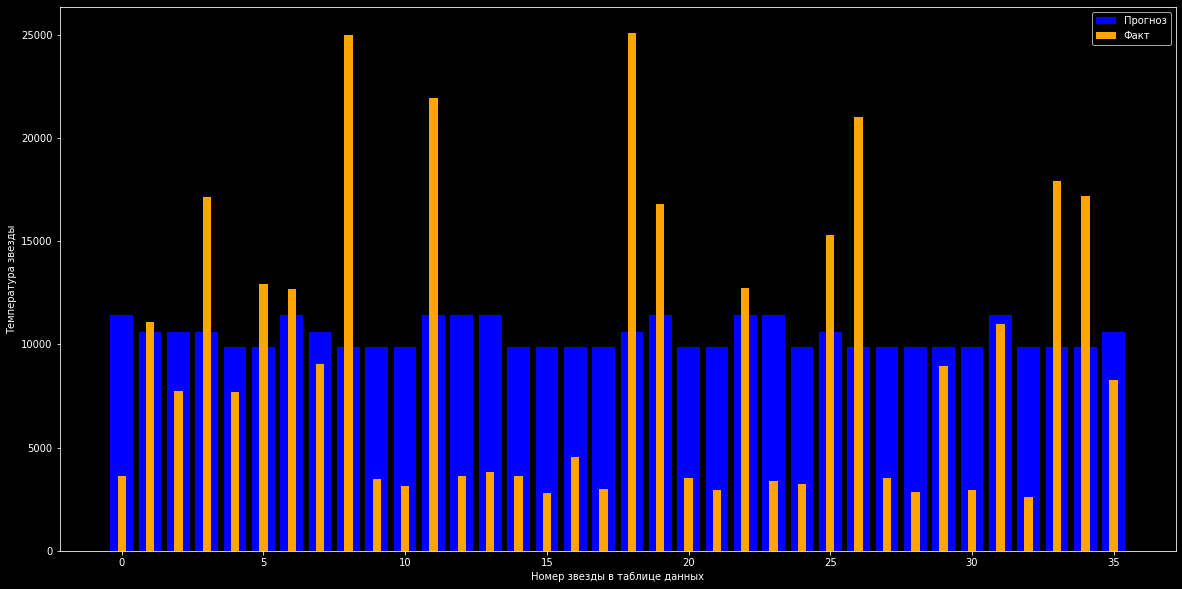

In [ ]:
pred = pd.DataFrame(net(X_valid).squeeze(-1).detach().numpy(), columns=['температура'])
y_val = pd.DataFrame(y_valid.detach().numpy(), columns=['температура'])

fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x=pred.index, height=pred['температура'], color='Blue' , label='Прогноз')
plt.bar(x=y_val.index, height=y_val['температура'], color='Orange', label='Факт', width= 0.3)
plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды')
plt.legend(loc="best")
plt.show()

### Нахождение лучших параметров и анализ работы 5-ти слойной архитектуры

Обучим сеть с 5-ю скрытыми слоями, кол-во нейронов в слоях уменьшим до 350

In [ ]:
h1 = list(range(100,350, 50))
h2 = list(range(100,350, 50))
h3 = list(range(100,350, 50))
h4 = list(range(100,350, 50))
h5 = list(range(100,350, 50))

In [ ]:
best_result = []
n_hidden_neurons_1_result = []
n_hidden_neurons_2_result = []
n_hidden_neurons_3_result = []
n_hidden_neurons_4_result = []
n_hidden_neurons_5_result = []
epoch_result = []
af1_result = []
af2_result = []
af3_result = []
af4_result = []
af5_result = []
lr_result = []
bs_result = []
p_drop_1_result = []
p_drop_2_result = []
p_drop_3_result = []
p_drop_4_result = []
p_drop_5_result = []
for i in range(n_iter):
    n_hidden_neurons_1 = h1[np.random.randint(0, len(h1))]
    n_hidden_neurons_2 = h2[np.random.randint(0, len(h2))]
    n_hidden_neurons_3 = h3[np.random.randint(0, len(h3))]
    n_hidden_neurons_4 = h4[np.random.randint(0, len(h4))]
    n_hidden_neurons_5 = h5[np.random.randint(0, len(h5))]
    af1 = af[np.random.randint(0, len(af))]
    af2 = af[np.random.randint(0, len(af))]
    af3 = af[np.random.randint(0, len(af))]
    af4 = af[np.random.randint(0, len(af))]
    af5 = af[np.random.randint(0, len(af))]
    lr_net = lr[np.random.randint(0, len(lr))]
    batch_size = batch_sizes[np.random.randint(0, len(batch_sizes))]
    drop_1 = p_drop[np.random.randint(0, len(p_drop))]
    drop_2 = p_drop[np.random.randint(0, len(p_drop))]
    drop_3 = p_drop[np.random.randint(0, len(p_drop))]
    drop_4 = p_drop[np.random.randint(0, len(p_drop))]
    drop_5 = p_drop[np.random.randint(0, len(p_drop))]

    data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

    net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    af1,
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    af2,
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    af3,
    nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
    af4,
    nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5),
    af5,
    nn.Linear(n_hidden_neurons_5, n_out_neurons)
    )
    net.apply(init_weights)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        for X_batch, y_batch in data_loader:
            preds = net.forward(X_batch).flatten()
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()

        if epoch % 100 == 0 or epoch == num_epochs - 1:
            net.eval()
            result = rmse(net(X_valid).squeeze(-1), y_valid)
            print(f'кол-во нейронов в 1-ом слое: {n_hidden_neurons_1}, кол-во нейронов в 2-ом слое: {n_hidden_neurons_2}, кол-во нейронов в 3-ем слое: {n_hidden_neurons_3}')
            print(f'кол-во нейронов в 4-ом слое: {n_hidden_neurons_4}, кол-во нейронов в 5-ом слое: {n_hidden_neurons_5}, номер эпохи: {epoch}, RMSE: {result}')
            print(f'функция активации 1-го слоя: {af1}, функция активации 2-го слоя: {af2}, функция активации 3-го слоя: {af3}')
            print(f'функция активации 4-го слоя: {af4}, функция активации 5 -го слоя: {af5},  скорость обучения: {lr_net}')
            print(f'размер батча: {batch_size}, dropout 1-го слоя: {drop_1}, dropout 2-го слоя: {drop_2}, dropout 3-го слоя: {drop_3}, dropout 4-го слоя: {drop_4}, dropout 5-го слоя: {drop_5}')
            print()
            best_result.append(result)
            n_hidden_neurons_1_result.append(n_hidden_neurons_1)
            n_hidden_neurons_2_result.append(n_hidden_neurons_2)
            n_hidden_neurons_3_result.append(n_hidden_neurons_3)
            n_hidden_neurons_4_result.append(n_hidden_neurons_4)
            n_hidden_neurons_5_result.append(n_hidden_neurons_5)
            epoch_result.append(epoch)
            af1_result.append(af1)
            af2_result.append(af2)
            af3_result.append(af3)
            af4_result.append(af4)
            af5_result.append(af5)
            lr_result.append(lr_net)
            bs_result.append(batch_size)
            p_drop_1_result.append(drop_1)
            p_drop_2_result.append(drop_2)
            p_drop_3_result.append(drop_3)
            p_drop_4_result.append(drop_4)
            p_drop_5_result.append(drop_5)

кол-во нейронов в 1-ом слое: 300, кол-во нейронов в 2-ом слое: 300, кол-во нейронов в 3-ем слое: 300
кол-во нейронов в 4-ом слое: 250, кол-во нейронов в 5-ом слое: 150, номер эпохи: 0, RMSE: 1472807.625
функция активации 1-го слоя: ReLU(), функция активации 2-го слоя: Tanh(), функция активации 3-го слоя: Tanh()
функция активации 4-го слоя: ReLU(), функция активации 5 -го слоя: ReLU(),  скорость обучения: 0.001
размер батча: 16, dropout 1-го слоя: 0.2, dropout 2-го слоя: 0.5, dropout 3-го слоя: 0.2, dropout 4-го слоя: 0.2, dropout 5-го слоя: 0.5

кол-во нейронов в 1-ом слое: 300, кол-во нейронов в 2-ом слое: 300, кол-во нейронов в 3-ем слое: 300
кол-во нейронов в 4-ом слое: 250, кол-во нейронов в 5-ом слое: 150, номер эпохи: 100, RMSE: 7056.06494140625
функция активации 1-го слоя: ReLU(), функция активации 2-го слоя: Tanh(), функция активации 3-го слоя: Tanh()
функция активации 4-го слоя: ReLU(), функция активации 5 -го слоя: ReLU(),  скорость обучения: 0.001
размер батча: 16, dropout 1

In [ ]:
print(f"лучший результат обучения, RMSE: {min(best_result)}")

лучший результат обучения, RMSE: 4112.576171875


In [ ]:
best_result_ = min(best_result)
best_id = best_result.index(best_result_)
best_id

156

In [ ]:
best_model_5_hidden = []
best_model_5_hidden.append(f"RMSE: {min(best_result)}")
best_model_5_hidden.append(f"Нейроны 1 слой: {n_hidden_neurons_1_result[best_id]}")
best_model_5_hidden.append(f"Нейроны 2 слой: {n_hidden_neurons_2_result[best_id]}")
best_model_5_hidden.append(f"Нейроны 3 слой: {n_hidden_neurons_3_result[best_id]}")
best_model_5_hidden.append(f"Нейроны 4 слой: {n_hidden_neurons_4_result[best_id]}")
best_model_5_hidden.append(f"Нейроны 5 слой: {n_hidden_neurons_5_result[best_id]}")
best_model_5_hidden.append(f"Функ. акт. 1 слоя: {af1_result[best_id]}")
best_model_5_hidden.append(f"Функ. акт. 2 слоя: {af2_result[best_id]}")
best_model_5_hidden.append(f"Функ. акт. 3 слоя: {af3_result[best_id]}")
best_model_5_hidden.append(f"Функ. акт. 4 слоя: {af4_result[best_id]}")
best_model_5_hidden.append(f"Функ. акт. 5 слоя: {af5_result[best_id]}")
best_model_5_hidden.append(f"learning rate: {lr_result[best_id]}")
best_model_5_hidden.append(f"Номер эпохи: {epoch_result[best_id]}")
best_model_5_hidden.append(f"dropout 1 слоя: {p_drop_1_result[best_id]}")
best_model_5_hidden.append(f"dropout 2 слоя: {p_drop_2_result[best_id]}")
best_model_5_hidden.append(f"dropout 3 слоя: {p_drop_3_result[best_id]}")
best_model_5_hidden.append(f"dropout 4 слоя: {p_drop_4_result[best_id]}")
best_model_5_hidden.append(f"dropout 5 слоя: {p_drop_5_result[best_id]}")
best_model_5_hidden.append(f"размер батча: {bs_result[best_id]}")
print('лучшие параметры сети с 5-ю скр. слоями:')

best_model_5_hidden

лучшие параметры сети с 5-ю скр. слоями:


['RMSE: 4112.576171875',
 'Нейроны 1 слой: 250',
 'Нейроны 2 слой: 250',
 'Нейроны 3 слой: 100',
 'Нейроны 4 слой: 100',
 'Нейроны 5 слой: 200',
 'Функ. акт. 1 слоя: Tanh()',
 'Функ. акт. 2 слоя: Tanh()',
 'Функ. акт. 3 слоя: Tanh()',
 'Функ. акт. 4 слоя: Tanh()',
 'Функ. акт. 5 слоя: ReLU()',
 'learning rate: 0.01',
 'Номер эпохи: 100',
 'dropout 1 слоя: 0',
 'dropout 2 слоя: 0.5',
 'dropout 3 слоя: 0.2',
 'dropout 4 слоя: 0.2',
 'dropout 5 слоя: 0.5',
 'размер батча: 128']

Лучший вариант архитектуры сети для графика 'факт-проноз':

In [ ]:
n_hidden_neurons_1 = 250
n_hidden_neurons_2 = 250
n_hidden_neurons_3 = 100
n_hidden_neurons_4 = 100
n_hidden_neurons_5 = 200
af1 = nn.Tanh()
af2 = nn.Tanh()
af3 = nn.Tanh()
af4 = nn.Tanh()
af5 = nn.ReLU()
lr_net = 1e-2
batch_size = 128
drop_1 = 0
drop_2 = 0.5
drop_3 = 0.2
drop_4 = 0.2
drop_5 = 0.5
num_epochs = 500

data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

net = nn.Sequential(
nn.Linear(n_in_neurons, n_hidden_neurons_1),
af1,
nn.Dropout(p=drop_1),
nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
af2,
nn.Dropout(p=drop_2),
nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
af3,
nn.Dropout(p=drop_3),
nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
af4,
nn.Dropout(p=drop_4),
nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5),
af5,
nn.Dropout(p=drop_5),
nn.Linear(n_hidden_neurons_5, n_out_neurons)
)
net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    for X_batch, y_batch in data_loader:
        preds = net.forward(X_batch).flatten()
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    if epoch % 100 == 0 or epoch == num_epochs - 1:
        net.eval()
result = rmse(net(X_valid).squeeze(-1), y_valid)
print(f"результат RMSE на валидации: {result}")

результат RMSE на валидации: 4976.490234375


График факт-проноз:

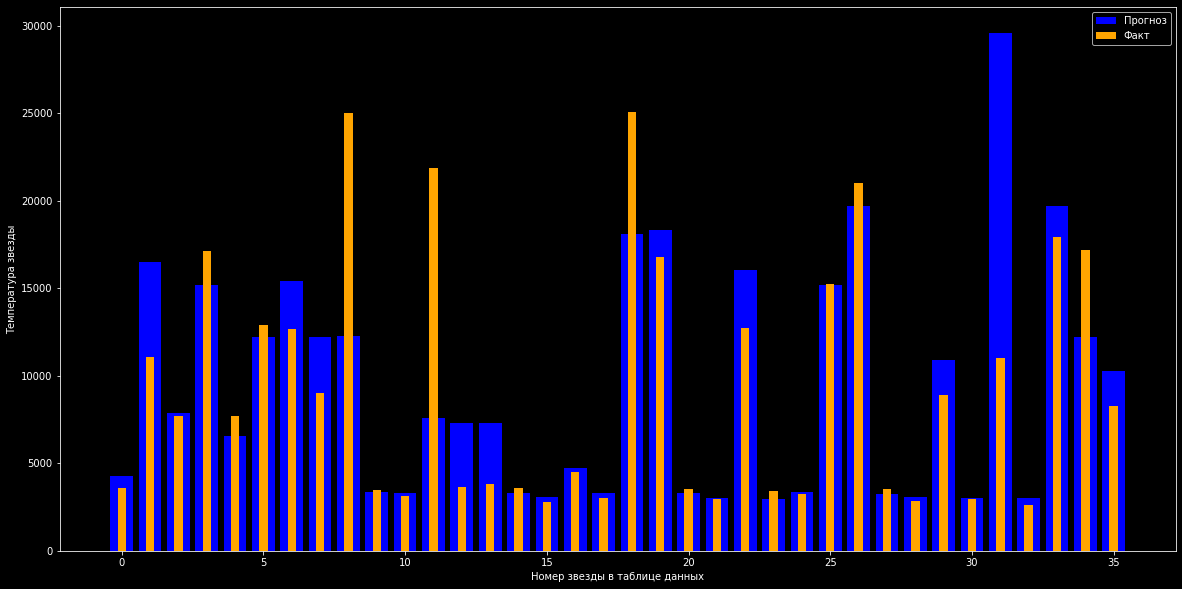

In [ ]:
pred = pd.DataFrame(net(X_valid).squeeze(-1).detach().numpy(), columns=['температура'])
y_val = pd.DataFrame(y_valid.detach().numpy(), columns=['температура'])

fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x=pred.index, height=pred['температура'], color='Blue' , label='Прогноз')
plt.bar(x=y_val.index, height=y_val['температура'], color='Orange', label='Факт', width= 0.3)
plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды')
plt.legend(loc="best")
plt.show()

### Итоговые результаты

Зафиксируем в таблицу общие результаты исследования с лучшими параметрами сетей:

In [ ]:
data = [["2 скрытых слоя", 850, 300, np.nan, np.nan, np.nan,
         'ReLU', 'ReLU', np.nan, np.nan, np.nan,
         0.2, 0, np.nan, np.nan, np.nan,
         0.1, 400, 16, 2742.12],
        ["3 скрытых слоя", 250, 400, 250, np.nan, np.nan,
         'Tanh', 'Tanh', 'ReLU', np.nan, np.nan,
         0.5, 0, 0, np.nan, np.nan,
         0.001, 500, 16, 2541.39],
        ["5 скрытых слоев", 250, 250, 100, 100, 200,
         'Tanh', 'Tanh', 'Tanh', 'Tanh', 'ReLU',
         0, 0.5, 0.2, 0.2, 0.5,
         0.01, 500, 128, 3823.20]]
column = ["архитектура сети","Нейроны 1-го слоя", "Нейроны 2-го слоя", "Нейроны 3-го слоя", "Нейроны 4-го слоя", "Нейроны 5-го слоя",
          "Функ. акт. 1-го слоя", "Функ. акт. 2-го слоя", "Функ. акт. 3-го слоя", "Функ. акт. 4-го слоя", "Функ. акт. 5-го слоя",
          "dropout 1-го слоя", "dropout 2-го слоя", "dropout 3-го слоя", "dropout 4-го слоя", "dropout 5-го слоя",
          "learning rate", "номер эпохи", "размер батча", "RMSE на валидации"]
data = pd.DataFrame(data, columns=column)

data

,архитектура сети,Нейроны 1-го слоя,Нейроны 2-го слоя,Нейроны 3-го слоя,Нейроны 4-го слоя,Нейроны 5-го слоя,Функ. акт. 1-го слоя,Функ. акт. 2-го слоя,Функ. акт. 3-го слоя,Функ. акт. 4-го слоя,Функ. акт. 5-го слоя,dropout 1-го слоя,dropout 2-го слоя,dropout 3-го слоя,dropout 4-го слоя,dropout 5-го слоя,learning rate,номер эпохи,размер батча,RMSE на валидации
0,2 скрытых слоя,850,300,NaN,NaN,NaN,ReLU,ReLU,NaN,NaN,NaN,0.2,0.0,NaN,NaN,NaN,0.100,400,16,2742.12
1,3 скрытых слоя,250,400,250.0,NaN,NaN,Tanh,Tanh,ReLU,NaN,NaN,0.5,0.0,0.0,NaN,NaN,0.001,500,16,2541.39
2,5 скрытых слоев,250,250,100.0,100.0,200.0,Tanh,Tanh,Tanh,Tanh,ReLU,0.0,0.5,0.2,0.2,0.5,0.010,500,128,3823.20


Обучим лучшую модель на тренировочных и валидационных данных, получим предсказание на тесте

In [ ]:
X_train_ = torch.cat((X_train, X_valid), 0)
y_train_ = torch.cat((y_train, y_valid), 0)

In [ ]:
n_hidden_neurons_1 = 250
n_hidden_neurons_2 = 400
n_hidden_neurons_3 = 250
af1 = nn.Tanh()
af2 = nn.Tanh()
af3 = nn.ReLU()
lr_net = 1e-3
batch_size = 16
drop_1 = 0.5
drop_2 = 0
drop_3 = 0
num_epochs = 500

data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_, y_train_), batch_size=batch_size, shuffle=True)

net = nn.Sequential(
nn.Linear(n_in_neurons, n_hidden_neurons_1),
af1,
nn.Dropout(p=drop_1),
nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
af2,
nn.Dropout(p=drop_2),
nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
af3,
nn.Dropout(p=drop_3),
nn.Linear(n_hidden_neurons_3, n_out_neurons)
)
net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    for X_batch, y_batch in data_loader:
        preds = net.forward(X_batch).flatten()
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    if epoch % 100 == 0 or epoch == num_epochs - 1:
        net.eval()

result = rmse(net(X_test).squeeze(-1), y_test)
print(f"результат RMSE на тесте: {result}")

результат RMSE на тесте: 3355.901611328125


Построем график «Факт — Прогноз» для анализа остатков

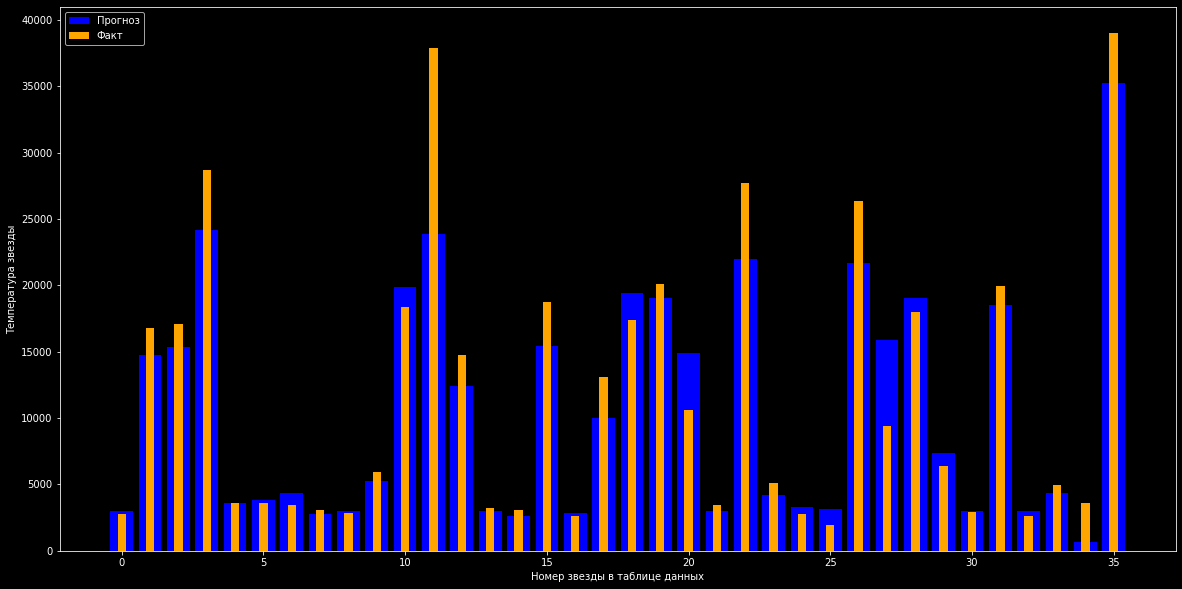

In [ ]:
pred = pd.DataFrame(net(X_test).squeeze(-1).detach().numpy(), columns=['температура'])
y_test = pd.DataFrame(y_test.detach().numpy(), columns=['температура'])

fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x=pred.index, height=pred['температура'], color='Blue' , label='Прогноз')
plt.bar(x=y_test.index, height=y_test['температура'], color='Orange', label='Факт', width= 0.3)
plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды')
plt.legend(loc="best")
plt.show()

Какой-то конкретный патерн промахов модели не наблюдается, модель как завышает так и занижает прогнозы на любых температурах

## Выводы

В проделанной работе есть промежуточные выводы, в общем выводе я бы хотел обобщить их и подвести итог по работе с данными

<h4>Загрузка данных</h4>

**Данные представленны в 1 файле:**

-В данных имеются, 1 колонка типа object, 3 колонки типа int, 3 колонки типа float, 240 строк

<h4>Предобработка данных</h4>

-Пропусков и явных дубликатов в данных не обнаружено

-Была проведена работа по приведению значений категори столбца 'Star color' к корректному виду

<h4>Исследовательский анализ данных</h4>

Проведено исследование **категориальных признаков:**

-Значения 'Star type'(тип звезды) типы звезд распределенны +- равномерно по данным

-Значения 'Star color'(Звёздный цвет) преобладает цвет звезд красного оттенка 'Red'(46,7%), меньше звезд с синего оттенка: 'Blue White', 'Blue' (по ~ 23-24%), желтый оттенок занимает самую наименьшую часть в данных (~10%)

Исследование **кол-ых признаков:**

-'Temperature (K)'(Абсолютная температура) целевой признак напоминает распределение Пуасона со 'скосом' к левому краю разброс варьируется от 1939 до 40000, в среднем 10497

Присутсвуют слегка выбивающиеся значения по правой стороне распределения

-'Luminosity(L/Lo)'(Относительная светимость) напоминает распределение Пуасона со 'скосом' к левому краю разброс варьируется от 0 до 849420, в среднем 107188

Присутсвуют слегка выбивающиеся значения по правой стороне распределения

-'Radius(R/Ro)'(Относительный радиус) напоминает распределение Пуасона со 'скосом' к левому краю разброс варьируется от 0 до 1948, в среднем 237

Присутствуют аномальные значения в правой части распределения

-'Absolute magnitude(Mv)'(Абсолютная звёздная величина) напоминает нормальное распределение с двумя пиковыми значениями на ~-7 и ~12, разброс варьируется от -11.9 до 20.06, в среднем 4.38

Аномальных значений не наблюдаем

<h4>Корреляционный анализ(train)</h4>

Построен "хитмап" по матрице корреляций Фик, есть сильная корреляция между 'Absolute magnitude(Mv)' и 'Star type' (0.92)

<h4>Построение базовой нейронной сети</h4>

-Данные поделены на тренировочные, валидационные и тестовые

-Проведено масштабирование и кодирование признаков

-Данные переведенны в тензоры

-В качестве модели по умолчанию выбранна архитектура сети с 2-мя скрытыми слоями, количество нейронов в скрытых слоях: 500, 800. В качестве алгоритма оптимизации выбран Adam, скорость обучения 1e-3. Выбранно для обучения 100 эпох.
Получившиеся результат RMSE на валидации: 11756.1182

<h4>Улучшение нейронной сети</h4>

-Создан перебор гиперпараметров сети, задан перебор кол-во нейронов в скрытых слоях, 15 итераций перебора. Кол-во эпох повышенно до 1000.

Лучший результат обучения, RMSE на валидации: 3424.763427734375

-Добавлен 3-ий скр. слой в сеть(до 500 нейронов), добавлен перебор learning_rate, функций активации. Обучение теперь производится по батчам c перебором размера батча и перебором доли Dropout нейронов после каждого слоя. Кол-во итераций перебора повышено до 50.Добавим метод init_weights для инициализации слоёв. Веса инициализируются с помощью нормального распределения с математическим ожиданием 0.5 и среднеквадратичным отклонением 2, а смещения — с помощью нормального распределения с математическим ожиданием 0.5 и среднеквадратичным отклонением 1.

Лучший результат обучения, RMSE: 3116.815185546875

-Обучена архитектура сети с 2-мя скрытыми слоями, увеличенно кол-во нейронов в слоях (до 1500), есть перебор вариантов функций активации, learning rate, размера батча, доли dropout после слоев

Лучший результат обучения, RMSE: 2779.82958984375

-Обучена сеть с 5-ю скрытыми слоями, кол-во нейронов в слоях уменьшенно до 350

Лучший результат обучения, RMSE: 4576.91796875

-Результаты исследования с лучшими параметрами разных архитектур сетей зафиксированно в таблице

-Обучена лучшая модель на тренировочных и валидационных данных, полученны предсказание на тесте

Результат RMSE на тесте: 4018.244140625

-Проведен анализ остатков.

Какой-то конкретный патерн промахов модели не наблюдается, модель как завышает так и занижает прогнозы на любых температурах